# Step by step

In order to understand how to run a Quantum Volume test with Qiskit we will follow these
steps:

* Create a random 2-qubit gate
* Create a gate layer
* Create a Quantum Volume circuit
* Simulate the circuit
* Get the heavy outputs of the circuit
* Run the circuit on a real quantum device
* Run the full Quantum Volume test

The first things we have to consider in order to calculate quantum volume is the amount of qubits and which ones we'll use. This amount of qubits will equal not only the width of the circuit but also its depth. 

In [1]:
# create a list with the qubits we want to use
qubit_list = [i for i in range(5)]

# save the length of the list = number of qubits = depth of the circuits = width of the circuits
SIZE = len(qubit_list)

## Create random 2-qubit gates

In order to measure quantum volume, we'll need to create random 2-qubit gates. That can be done with the `random_unitary` function from `qiskit.quantum_info`.

In [2]:
from qiskit.quantum_info import random_unitary
# create a random 4x4 unitary matrix i.e. a random 2-qubit operator
random_unitary(4)

Operator([[ 0.22135758-0.18654922j, -0.54570703+0.11067592j,
           -0.42865832-0.47181766j,  0.01161354+0.44683348j],
          [ 0.62744197+0.15964268j,  0.05480969+0.4823489j ,
           -0.1231835 +0.06476647j, -0.46251612-0.33447899j],
          [ 0.27109868-0.18618368j,  0.43031042-0.31670409j,
           -0.34289521-0.4415057j ,  0.35190968-0.41234425j],
          [ 0.15128686+0.60496646j,  0.27138866-0.308496j  ,
           -0.44568496+0.2512604j , -0.02823112+0.42396039j]],
         input_dims=(2, 2), output_dims=(2, 2))

## Create a gate layer

Now that we have the needed gates, let's start by using them with pairs of adjacent qubits. If we have an odd number of qubits, one of them will be left unchanged.

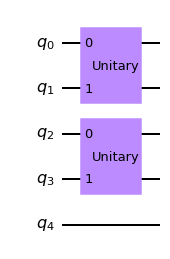

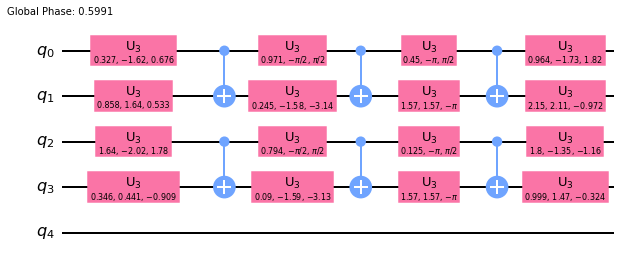

In [3]:
from qiskit import QuantumCircuit

# create the circuit corresponding to the first layer
qv_layer = QuantumCircuit(SIZE)

# iterate over the pairs of qubits, of which there are the integer part of SIZE/2
for pair in range(SIZE//2):
    # choose indexes
    qubit_indices = qubit_list[pair * 2 : pair * 2 + 2]
    # create gate
    gate = random_unitary(2 * (SIZE//2)).to_instruction()
    # add gate to circuit
    qv_layer.append(gate, qubit_indices)

# show the layer circuit
display(qv_layer.draw("mpl"))

# show a more detailed version of the layer circuit
display(qv_layer.decompose().draw("mpl"))

## Create a Quantum Volume circuit

The next step will be creating a circuit with `SIZE` layers instead of only one. Before each layer we have to randomly permutate the qubits, what can be done with the `shuffle` function from `random`. 

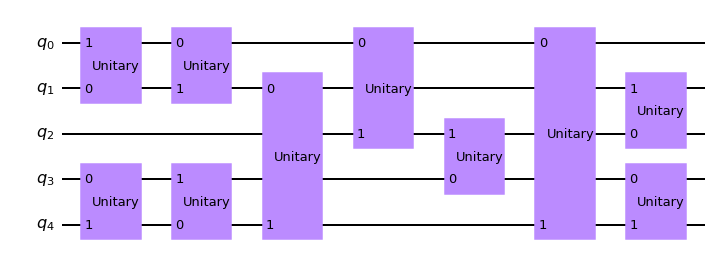

In [4]:
from random import shuffle

qlist = qubit_list[:]

# create the circuit
qv_circ = QuantumCircuit(SIZE)

# randomly permutate the list of qubits and add a layer SIZE = depth times
for i in range(SIZE):
    shuffle(qlist)
    for pair in range(SIZE//2):
        qubit_indices = qlist[pair * 2 : pair * 2 + 2]
        gate = random_unitary(2 * (SIZE//2)).to_instruction()
        qv_circ.append(gate, qubit_indices)

#show the circuit
display(qv_circ.draw("mpl"))

However, `qiskit` already has a class called `QuantumVolume` in their module `qiskit.circuit.library` that directly creates this kind of circuits for us so, in practice, we don't have to worry about how they are built.

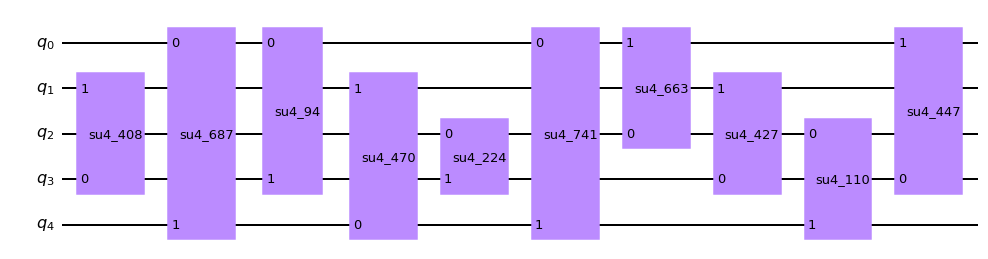

In [5]:
from qiskit.circuit.library import QuantumVolume

qv_circ = QuantumVolume(SIZE)

qv_circ.decompose().draw("mpl")

This is the circuit that will be used from now on.

## Simulate the circuit

Now we'll use the simulator `aer_simulator` from `Aer` to obtain the ideal probability distribution of the outputs of our circuit. In other words, we'll see what we should get if we ran our circuit with an ideal quantum computer.

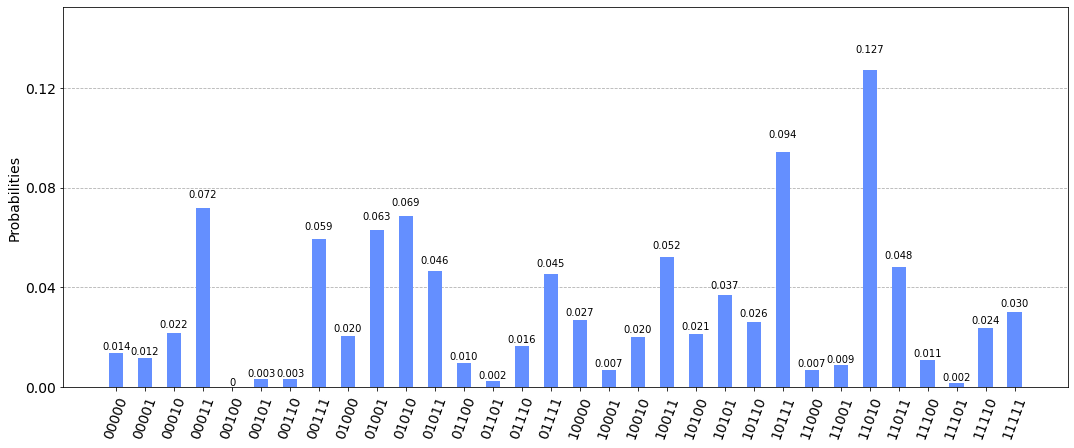

In [6]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

# define the simulator
simulator = Aer.get_backend("aer_simulator")

# transpile the circuit so it can be used with the simulator
t_qv_circ = transpile(qv_circ, simulator)

# save the statevector of the circuit
t_qv_circ.save_statevector()

# run the simulator to get the probability distribution from the statevector
counts = simulator.run(t_qv_circ).result().get_counts()

# represent the probability distribution with an histogram
plot_histogram(counts, figsize = (18,7))

## Get the heavy outputs of the circuit

The part of the probability distribution that will be interesting to us is the heavy outputs, the outputs whose probability is higher than the median's. We can select these values by ordering our list of outputs by probability with `sorted` and then selecting the second half of the indices.

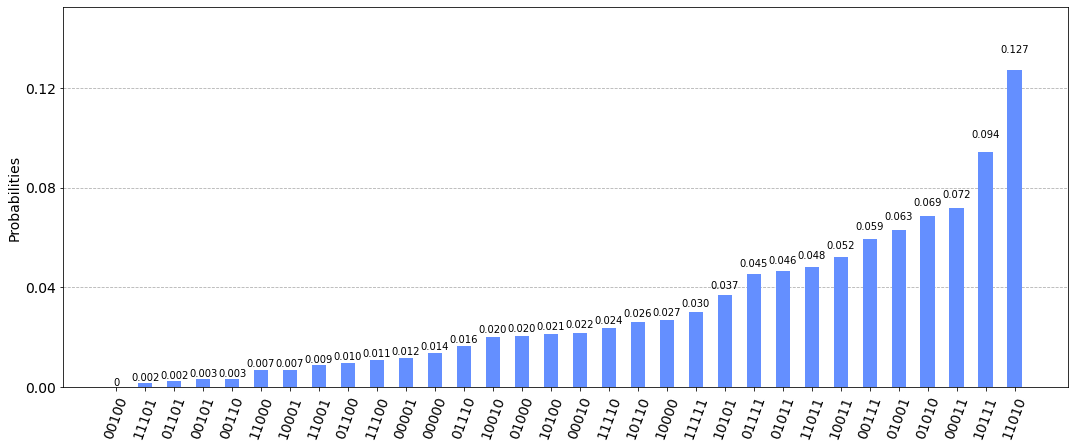

The heavy outputs of this circuit are: ['00010', '11110', '10110', '10000', '11111', '10101', '01111', '01011', '11011', '10011', '00111', '01001', '01010', '00011', '10111', '11010']


In [7]:
# order the bars of the histogram by ascending probability
display(plot_histogram(counts, figsize=(18,7), sort='value'))

# sort the list of outputs by probability
sorted_counts = sorted(counts.keys(), key=counts.get)

# pick the heavy outputs
heavy_outputs = sorted_counts[len(sorted_counts)//2 : ]

# show the heavy outputs
print("The heavy outputs of this circuit are:", heavy_outputs)

## Run the circuit on a real quantum device

After getting our heavy output list we can start thinking about running our circuit with an actual quantum computer. One way of doing this is by using `IBMQ`. Keep in mind that for this to work it is necessary to have an IBM Quantum accountthat can be created for free in [IBM Quantum's web page](https://quantum-computing.ibm.com/). It can be loaded with the following commands:

In [8]:
from qiskit import IBMQ

# save IBMQ account
#IBMQ.save_account(api_key)

# load IBMQ account
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Once we have loaded the account, we need to choose a provider, from which we will be able to pick our desired device. As an IBM intern, I was granted access to the hub `'ibm-q-internal'`, which has a wider array of available computers than the free basic pack. 

In [9]:
# select provider
provider = IBMQ.get_provider(hub='ibm-q-internal')

Let's see what quantum systems we can have access to.

In [10]:
# show backends
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-internal', group='deployed', project='default')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-internal', group='deployed', project

For this example, we will use the `'ibmq_montreal'` backend.

In [11]:
# choose quantum computer
backend = provider.get_backend('ibmq_montreal')

We can take a look into the coupling graph of the device, the error rate of each qubit, the CNOT error corresponding to each pair of qubits and the error rate of a Hadamard gate applied on each qubit using the `plot_error_map` function from the module `qiskit.visualization`.

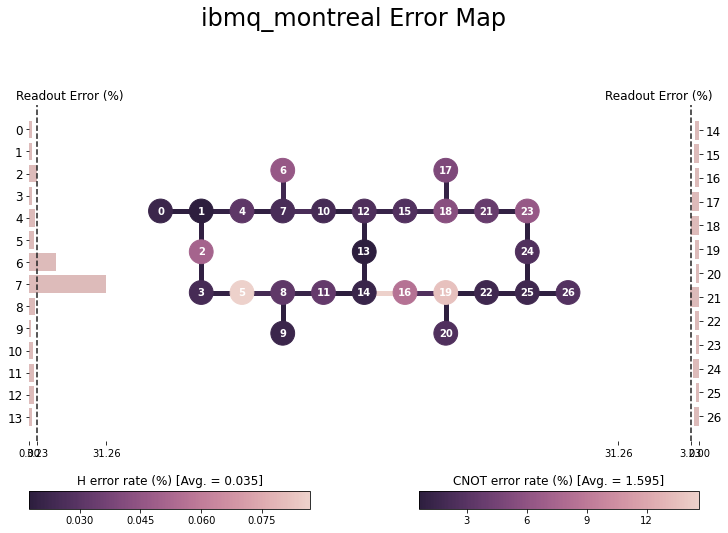

In [12]:
from qiskit.visualization import plot_error_map
plot_error_map(backend)

It is also possible to look into some of the properties of the each device by using the `IBMQBackend.properties()` method. For example, we can look into the error rates of each CNOT gate to get a more exact description than the colors from `plot_error_map`, that can be obscured if there are some extreme values.

In [13]:
for i in backend.properties().gates:
    if "cx" in i.name:
        print(f"{i.name}, that acts on qubits {i.qubits} and has error rate of {i.parameters[0].value}")

cx22_19, that acts on qubits [22, 19] and has error rate of 0.00708146039993382
cx19_22, that acts on qubits [19, 22] and has error rate of 0.00708146039993382
cx21_18, that acts on qubits [21, 18] and has error rate of 0.013536296018506977
cx18_21, that acts on qubits [18, 21] and has error rate of 0.013536296018506977
cx16_19, that acts on qubits [16, 19] and has error rate of 0.026302695327298453
cx19_16, that acts on qubits [19, 16] and has error rate of 0.026302695327298453
cx15_18, that acts on qubits [15, 18] and has error rate of 0.015797993184110765
cx18_15, that acts on qubits [18, 15] and has error rate of 0.015797993184110765
cx11_14, that acts on qubits [11, 14] and has error rate of 0.0060997466690941304
cx14_11, that acts on qubits [14, 11] and has error rate of 0.0060997466690941304
cx23_21, that acts on qubits [23, 21] and has error rate of 0.00985424022906986
cx21_23, that acts on qubits [21, 23] and has error rate of 0.00985424022906986
cx10_7, that acts on qubits [1

In order to run the circuit on the quantum computer, we need to add measures to it. If this is not done, we will not get any significant result. A quick way to do this is using the `QuantumCircuit.measure_all()` method, that automatically adds a classical register with as many bits as qubits we have in our circuit and measures all of the qubits into their corresponding bit. After that, we run the circuit `qv_circ` several times, in this case`n_shots` = 1024, and check how many heavy outputs we got.

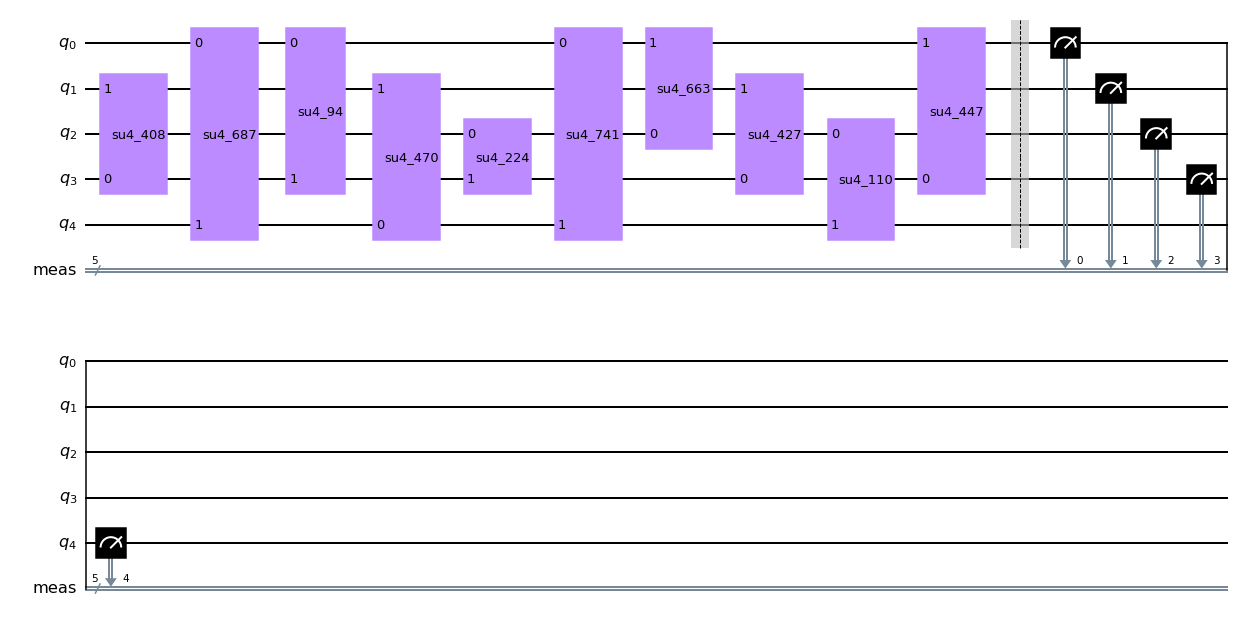

After running the circuit 1024 times, we got 641 heavy outputs


In [14]:
n_shots = 1024

# measure the circuit in order to get something meaningful from the quantum computer.
qv_circ.measure_all()

# show the circuit with the measures
display(qv_circ.decompose().draw("mpl"))

# transpile the circuit according to the backend
transpiled_qv_circ = transpile(qv_circ, backend)

# run the circuit on the backend
job = backend.run(transpiled_qv_circ, shots=n_shots)

# take the results
device_counts = job.result().get_counts()

# initialize number of heavy outputs
n_heavy = 0
# check if they are heavy outputs
for heavy_output in heavy_outputs:
    if heavy_output in device_counts.keys():
        n_heavy += device_counts[heavy_output]
n_heavy = int(n_heavy)

print("After running the circuit", n_shots, "times, we got", n_heavy, "heavy outputs")

## Run the full Quantum Volume test

Now that we have seen how to create a quantum volume circuit, get its heavy outputs and run it on an actual quantum computer, it's time to do the same for `n_circuits` different circuits. We will first start by creating a list of circuits and another list with their corresponding heavy outputs.

In [15]:
from qiskit import Aer, transpile, QuantumCircuit, IBMQ
from qiskit.circuit.library import QuantumVolume
import numpy as np

# select the depth and width of the QV circuits
SIZE = 5

# number of times we will run each circuit
n_shots = 10000

# choose simulator
simulator = Aer.get_backend("aer_simulator")

# load IBMQ account
IBMQ.load_account()

# select provider
provider = IBMQ.get_provider(hub = 'ibm-q-internal')

# choose quantum computer
backend = provider.get_backend('ibmq_montreal')

# number of different circuits set to maximum permitted per job with this particular backend
n_circuits = 1000

# initialize a list of all the circuits
circuit_list = []

# initialize list of heavy outputs
heavy_outputs_list = []


for circuit in range(n_circuits):
    # create the QV circuit
    qv_circ = QuantumVolume(SIZE)
    # transpile circuit to use the simulator
    qv_circ_simulator = transpile(qv_circ, simulator)
    # save the statevector of the circuit
    qv_circ_simulator.save_statevector()
    # get probabilities
    counts = simulator.run(qv_circ_simulator).result().get_counts()
    # sort the results by probability
    sorted_counts = sorted(counts.keys(), key = counts.get)
    # pick the heavy outputs
    heavy_outputs = sorted_counts[len(sorted_counts)//2 : ]

    # add heavy outputs to list
    heavy_outputs_list.append(heavy_outputs)

    # measure the circuit before running it through the quantum computer
    qv_circ.measure_all()

    # add the circuit to the list
    circuit_list.append(qv_circ)

# transpile the circuits so they can be run on the quantum computer
transpiled_circuits = transpile(circuit_list, backend)

ibmqfactory.load_account:WARNING:2022-08-21 03:27:01,624: Credentials are already in use. The existing account in the session will be replaced.


The next step is, as expected, running the circuits on the backend. In theory we would only need to run `backend.run(transpiled_circuits, shots=n_shots)` but there are some limitations that we have to take into account. Each device has a maximum limit of circuits allowed and, if we try to run more than that, we will get an error. This limit can be checked with the following command.

In [16]:
max_circuits = backend.configuration().max_experiments
max_circuits

900

A possible way to circumvent this limit would be breaking the circuit list `transpiled_circuits` into lists of size `max_circuits` and a final list with the rest of executions and then checking for each circuit the number of heavy outputs obtained. 

In [17]:
# initialize the number of heavy outputs
n_heavy = 0

# we split the executions according to the maximum number of circuits allowed by the device
max_circuits = backend.configuration().max_experiments

for i in range(n_circuits//max_circuits):
    # run max_circuits circuits on the backend
    job = backend.run(transpiled_circuits[i * max_circuits : (i+1) * max_circuits], shots=n_shots)
    # take the results
    device_counts = job.result().get_counts()
    # check if they are heavy outputs
    for j in range(max_circuits):
        for heavy_output in heavy_outputs_list[i * max_circuits + j]:
            if heavy_output in device_counts[j].keys():
                n_heavy += device_counts[j][heavy_output]

if (i+1) * max_circuits != n_circuits:
    # run rest of circuits on the backend if there are any
    job = backend.run(transpiled_circuits[(i+1) * max_circuits : n_circuits], shots=n_shots)
    # take the results
    device_counts = job.result().get_counts()
    # check if they are heavy outputs
    for j in range(n_circuits - (i+1) * max_circuits):
        for heavy_output in heavy_outputs_list[(i+1) * max_circuits + j]:
            if heavy_output in device_counts[j].keys():
                n_heavy += device_counts[j][heavy_output]
n_heavy = int(n_heavy)

However, Qiskit also includes a job manager called `IBMQJobManager` that already handles this for us in a more optimal way.

In [18]:
from qiskit.providers.ibmq.managed import IBMQJobManager

# initialize job manager
job_manager = IBMQJobManager()

# run the circuits with the job manager
job = job_manager.run(transpiled_circuits, backend=backend, shots=n_shots)


An impotant detail when using the `IBMQJobManager` is that the way to get the results has a slightly different syntax than usual. For a standard job, we would run `job.result().get_counts()` to get a list of dictionaries, each one corresponding to a circuit. However, for this managed job, we can only get the dictionaries one by one with `job.results().get_counts(i)` for the $i$-th circuit. Note that this time we change `result` for `results`.

Apart from counting the heavy outputs, this time we are going to keep track of the experimental probability of heavy outputs of each circuit, $\frac{n_{hj}}{n_s}$, the cumulated heavy output probability $\frac{\sum_{k=0}^{j}n_{hk}}{(j+1)n_s}$ and the cumulated $2 \sigma$ given by $\frac{2\sqrt{\sum_{k=0}^{j}n_{hk}\big(n_s-\frac{\sum_{k=0}^j n_{hk}}{j+1}\big)}}{(j+1)n_s}$ in order to represent the results of the experiment.

In [19]:
# initialize the number of heavy outputs
n_heavy = 0

# initialize cumulated heavy output probability (HOP), individual HOP and interval
hop_cumulated = np.array([])
hop_individual = []
interval = np.array([])

for j in range(n_circuits):
    # initialize the number of heavy outputs of circuit j
    n_heavy_j = 0
    # get dictionary of results from circuit j
    device_counts = job.results().get_counts(j)
    # check which results are heavy outputs
    for heavy_output in heavy_outputs_list[j]:
        if heavy_output in device_counts.keys():
            n_heavy_j += device_counts[heavy_output]
    # add the heavy outputs of the circuit to the total count
    n_heavy += n_heavy_j
    # update individual HOP, cumulated HOP and interval
    hop_individual.append(n_heavyj/n_shots)
    hop_cumulated = np.append(hop_cumulated ,n_heavy/((j+1)*n_shots))
    interval = np.append(interval, 2 * np.sqrt( n_heavy * ( n_shots - n_heavy/(j+1)) )/(n_shots*(j+1)))


account._job_result_object_storage:WARNING:2022-08-21 04:35:44,040: An error occurred while sending download completion acknowledgement: "('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))"


Now that all the circuits have been run, it's time to check if the quantum volume is achieved. So we want to know whether $$\frac{n_h-2\sqrt{n_h\big(n_s-\frac{n_h}{n_c}\big)}}{n_cn_s}>\frac{2}{3}.$$

In [20]:
# show the parameters we'll use to determine the quantum volume    
print("n_c: ", n_circuits, "\nn_s: ", n_shots, "\nn_h: ", n_heavy) 

# determine if the quantum volume is achieved
if (n_heavy - 2 * np.sqrt(n_heavy * (n_shots - n_heavy / n_circuits)))/(n_shots * n_circuits) > 2/3:
    print("Success! Quantum Volume of", 2**SIZE, "achieved!")
else:
    print("Quantum Volume", 2**SIZE ,"test failed, ", (n_heavy - 2 * np.sqrt(n_heavy * (n_shots - n_heavy / n_circuits)))/(n_shots * n_circuits), "< 2/3")

n_c:  1000 
n_s:  10000 
n_h:  6052202
Quantum Volume 32 test failed,  0.5743055620747737 < 2/3


A way to see how close we got to actually passing the test, it is useful to visually represent the data. In particular we will plot the individual and cumulated heavy output probabilities, the latter of which will be surrounded by a shaded $\pm 2 \sigma$ region.

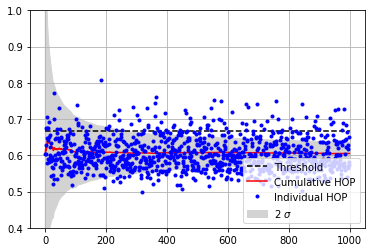

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot([0, n_circuits], [2/3, 2/3], '--', color = 'black')
ax.plot(range(n_circuits), hop_cumulated, '-', color = 'red')
ax.plot(range(n_circuits), hop_individual, '.', color = 'blue')
ax.fill_between(range(n_circuits), hop_cumulated - interval, hop_cumulated + interval, color = 'lightgrey')
plt.grid()
plt.ylim([0.4,1])
ax.legend(['Threshold', 'Cumulated HOP', 'Individual HOP', '2 $\\sigma$'], loc = 'lower right')

The Quantum Volume test would be passed if the lower part of the interval goes above the $2/3$ threshold. As we can see, the interval becomes narrower when the number of circuits increases. Generally, if the cumulated HOP is consistently above the threshold, it should be theoretically possible to pass the test with a big enough number of circuits. However, this decrease of width becomes less noticeable when the number of circuits increases, so it can sometimes become unfeasible in practice.